In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

January data

In [2]:
df = pd.read_csv('/Users/chenyian/DS_mini_project/drive-download-20240302T104351Z-001/merged_2025-01.csv')

df

,Day,Time,Bid1,Bid2,Ask1,Ask2,Mid_Price,Total_volume,Bid_ask_spread,Order_imbalance
0,2025/1/2,7:30:00,"[1.0, 6]","[0, 0]","[0, 0]","[0, 0]",0.50,6,-1.00,1.00
1,2025/1/2,7:30:01,"[27.0, 20]","[1.0, 12]","[798.4, 5]","[0, 0]",412.70,37,771.40,0.73
2,2025/1/2,7:30:02,"[261.75, 8]","[21.0, 13]","[306.46, 13]","[403.57, 7]",284.11,41,44.71,0.02
3,2025/1/2,7:30:03,"[262.75, 48]","[261.0, 8]","[292.56, 16]","[294.59, 32]",277.66,104,29.81,0.08
4,2025/1/2,7:30:04,"[264.0, 36]","[261.0, 6]","[287.45, 20]","[288.1, 21]",275.73,83,23.45,0.01
...,...,...,...,...,...,...,...,...,...,...
642566,2025/1/30,15:59:55,"[322.46, 13]","[320.57, 42]","[324.85, 39]","[327.5, 40]",323.65,134,2.38,-0.18
642567,2025/1/30,15:59:56,"[322.0, 21]","[320.0, 27]","[324.0, 27]","[330.56, 27]",323.00,102,2.00,-0.06
642568,2025/1/30,15:59:57,"[322.0, 36]","[320.0, 45]","[329.8, 45]","[335.64, 84]",325.90,210,7.80,-0.23
642569,2025/1/30,15:59:58,"[322.0, 20]","[320.0, 30]","[329.43, 35]","[333.57, 37]",325.71,122,7.43,-0.18


70%-20%-10% split

In [3]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [4]:
train_mp = train_df['Mid_Price']
val_mp = val_df['Mid_Price']
test_mp = test_df['Mid_Price'] 

Normalising the data

In [5]:
train_mean = train_mp.mean()
train_std = train_mp.std()

train_nr = (train_mp - train_mean)/train_std
val_nr = (val_mp - train_mean)/train_std
test_nr = (test_mp - train_mean)/train_std

Windowing

In [6]:
def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

In [7]:
input_sequence_length = 50
forecast_horizon = 10

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((449740, 50),
 (449740, 10),
 (128455, 50),
 (128455, 10),
 (64199, 50),
 (64199, 10))

In [8]:
# change the shape to fit the LSTM model

X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]


y_train = y_train[:, :, np.newaxis]
y_val = y_val[:, :, np.newaxis]
y_test = y_test[:, :, np.newaxis]

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((449740, 50, 1),
 (449740, 10, 1),
 (128455, 50, 1),
 (128455, 10, 1),
 (64199, 50, 1),
 (64199, 10, 1))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [10]:
OUT_STEPS = 10
num_features = 1

lstm_model = Sequential([
    layers.LSTM(32),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/20


2024-03-18 09:08:18.264115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 09:08:18.265070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-18 09:08:18.419940: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-18 09:08:19.239323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-18 09:08:19.403841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-18 09:08:19.587299: I tensorflow/core/grappler/o

14055/14055 [==============================] - ETA: 0s - loss: 0.3221 - mean_absolute_error: 0.2703

2024-03-18 09:12:34.943081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-18 09:12:35.005525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14055/14055 [==============================] - 296s 21ms/step - loss: 0.3221 - mean_absolute_error: 0.2703 - val_loss: 0.4569 - val_mean_absolute_error: 0.3422
Epoch 2/20
14055/14055 [==============================] - 293s 21ms/step - loss: 0.3098 - mean_absolute_error: 0.2616 - val_loss: 0.4559 - val_mean_absolute_error: 0.3505
Epoch 3/20
14055/14055 [==============================] - 295s 21ms/step - loss: 0.3064 - mean_absolute_error: 0.2597 - val_loss: 0.4494 - val_mean_absolute_error: 0.3379
Epoch 4/20
14055/14055 [==============================] - 324s 23ms/step - loss: 0.3043 - mean_absolute_error: 0.2588 - val_loss: 0.4507 - val_mean_absolute_error: 0.3392
Epoch 5/20
14055/14055 [==============================] - 317s 23ms/step - loss: 0.3026 - mean_absolute_error: 0.2582 - val_loss: 0.4531 - val_mean_absolute_error: 0.3469
Epoch 6/20
14055/14055 [==============================] - 320s 23ms/step - loss: 0.3008 - mean_absolute_error: 0.2575 - val_loss: 0.4536 - val_mean_absolute

KeyboardInterrupt: 

In [30]:
x_input = np.expand_dims(X_test[0], axis=0)

# Now x_input has shape (1, timesteps, features)
y0_pred = lstm_model.predict(x_input)

In [31]:
y0_pred.shape

(1, 10, 1)

In [32]:
y0_pred

array([[[1.4048504],
        [1.3950534],
        [1.3853322],
        [1.3453727],
        [1.3295223],
        [1.3119004],
        [1.3227053],
        [1.3217578],
        [1.3499906],
        [1.3701711]]], dtype=float32)

In [33]:
y_test[0]

array([[1.40020495],
       [1.54559223],
       [1.64251707],
       [1.63314767],
       [1.61311654],
       [1.60083939],
       [1.54720764],
       [1.61925511],
       [1.4990683 ],
       [1.44123647]])

In [37]:
x_input[:,-1]

array([[1.40408195]])

In [38]:
np.mean(y0_pred)

1.3536656

In [39]:
np.mean(y_test[0])

1.554218537433623

In [40]:
x_input1 = np.expand_dims(X_test[1], axis=0)

# Now x_input has shape (1, timesteps, features)
y1_pred = lstm_model.predict(x_input1)

In [41]:
y1_pred

array([[[1.4155594],
        [1.407046 ],
        [1.3981781],
        [1.3584292],
        [1.3420728],
        [1.3231003],
        [1.3315523],
        [1.3295324],
        [1.3558943],
        [1.3750975]]], dtype=float32)

In [42]:
y_test[1]

array([[1.54559223],
       [1.64251707],
       [1.63314767],
       [1.61311654],
       [1.60083939],
       [1.54720764],
       [1.61925511],
       [1.4990683 ],
       [1.44123647],
       [1.41312827]])

In [43]:
np.mean(y1_pred)

1.3636461

In [44]:
np.mean(y_test[1])

1.5555108687421115

In [46]:
x_input[:,-1]

array([[1.40408195]])

In [49]:
x_ = np.arange(len(y_test))

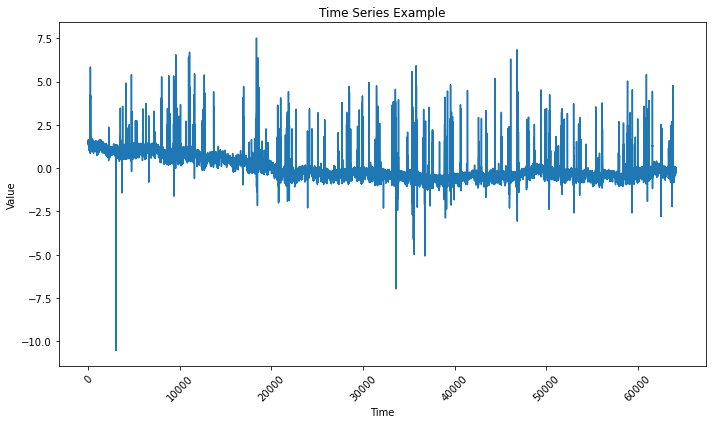

In [52]:
plt.figure(figsize=(10, 6))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [53]:
y_pred = lstm_model.predict(X_test)

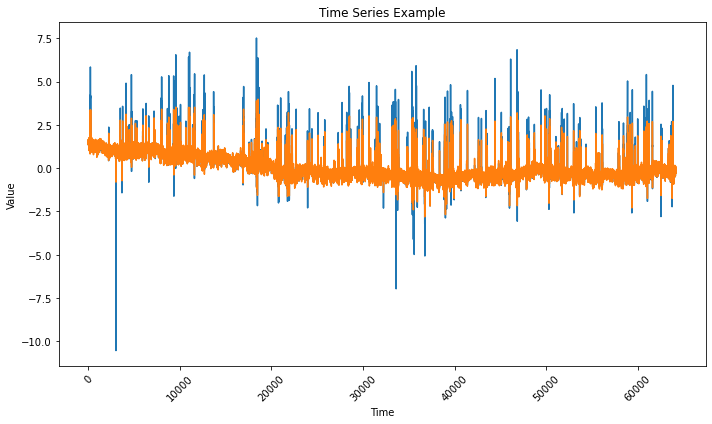

In [54]:
plt.figure(figsize=(10, 6))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.plot(x_, y_pred[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [55]:
np.mean(np.square(y_pred[:,0] - y_test[:,0]))

0.0733137066994526